In [1]:
!pip3 -q install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 34.7 MB/s eta 0:00:00


In [2]:
import zipfile
import os
import random
import shutil
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch

In [4]:
from tqdm import tqdm
def create_yolo_annotations(base_path, output_images_path, output_labels_path, split_ratio):
    os.makedirs(os.path.join(output_images_path, 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_images_path, 'val'), exist_ok=True)
    os.makedirs(os.path.join(output_labels_path, 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_labels_path, 'val'), exist_ok=True)

    classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'sub', 'mul', 'div', 'eq']

    for class_name in tqdm(classes):
        class_path = os.path.join(base_path, class_name)
        images = [img for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

        random.shuffle(images)

        split_index = int(len(images) * split_ratio)

        train_images = images[:split_index]
        val_images = images[split_index:]

        for split, img_list in zip(['train', 'val'], [train_images, val_images]):
            for image in img_list:
                image_path = os.path.join(class_path, image)
                new_image_path = os.path.join(output_images_path, split, image)
                shutil.copy(image_path, new_image_path)

                img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
                contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                if contours:
                    mask = np.zeros_like(img)
                    for contour in contours:
                        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
                    x, y, w, h = cv2.boundingRect(mask)
                    img_h, img_w = img.shape
                    x_center = (x + w / 2) / img_w
                    y_center = (y + h / 2) / img_h
                    w = w / img_w
                    h = h / img_h

                    label_path = os.path.join(output_labels_path, split, image.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt'))
                    with open(label_path, 'w') as label_file:
                        label_file.write(f"{classes.index(class_name)} {x_center} {y_center} {w} {h}\n")

base_path = '/kaggle/input/handwritten-math-symbols/dataset'  
output_images_path = '/kaggle/working/images'
output_labels_path = '/kaggle/working/labels'
create_yolo_annotations(base_path, output_images_path, output_labels_path, split_ratio=0.9) 

100%|██████████| 15/15 [00:43<00:00,  2.88s/it]


In [5]:
data_yaml_content = """
train: /kaggle/working/images/train
val: /kaggle/working/images/train

nc: 15
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add' , 'sub' , 'mul' , 'div', 'eq']
"""

with open('/kaggle/working/data.yaml', 'w') as f:
    f.write(data_yaml_content)

In [6]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
model = YOLO('yolo11l.pt')

100%|██████████| 49.0M/49.0M [00:00<00:00, 253MB/s]


In [8]:
model.train(data="/kaggle/working/data.yaml", epochs=30, imgsz=128)

Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/working/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True,

100%|██████████| 755k/755k [00:00<00:00, 45.8MB/s]


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 175MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/labels/train... 7122 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7122/7122 [00:05<00:00, 1312.97it/s]


train: New cache created: /kaggle/working/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/labels/train.cache... 7122 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7122/7122 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 128 train, 128 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30       1.2G     0.7502      1.648      1.082          2        128: 100%|██████████| 446/446 [01:14<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:29<00:00,  7.51it/s]


                   all       7122       7122      0.881      0.911      0.951      0.863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       1.2G      0.679      1.033      1.058          4        128: 100%|██████████| 446/446 [01:09<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.02it/s]


                   all       7122       7122      0.879      0.932      0.976      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30       1.2G     0.6689     0.9743      1.052          5        128: 100%|██████████| 446/446 [01:07<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.07it/s]

                   all       7122       7122      0.925      0.941      0.978      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30       1.2G     0.6301     0.9184      1.036          6        128: 100%|██████████| 446/446 [01:07<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.13it/s]

                   all       7122       7122      0.925       0.93      0.971      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       1.2G     0.6009     0.8494      1.027          3        128: 100%|██████████| 446/446 [01:06<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.05it/s]

                   all       7122       7122       0.95      0.954      0.972      0.917



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30       1.2G     0.5756     0.8221      1.014          4        128: 100%|██████████| 446/446 [01:06<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.10it/s]

                   all       7122       7122      0.969      0.975      0.991      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       1.2G     0.5564     0.7795      1.005          5        128: 100%|██████████| 446/446 [01:07<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.17it/s]

                   all       7122       7122      0.976      0.979      0.992      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30       1.2G     0.5366     0.7646          1          6        128: 100%|██████████| 446/446 [01:08<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.01it/s]

                   all       7122       7122      0.969      0.979      0.992      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30       1.2G     0.5273     0.7341     0.9954          3        128: 100%|██████████| 446/446 [01:07<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.04it/s]

                   all       7122       7122      0.977      0.985      0.988      0.966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30       1.2G      0.515     0.7245     0.9916          5        128: 100%|██████████| 446/446 [01:06<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.17it/s]

                   all       7122       7122      0.988       0.99      0.994      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30       1.2G     0.4952      0.693     0.9808          6        128: 100%|██████████| 446/446 [01:06<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.18it/s]

                   all       7122       7122      0.983      0.989      0.994      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30       1.2G     0.4907     0.6932     0.9835          4        128: 100%|██████████| 446/446 [01:07<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.10it/s]

                   all       7122       7122      0.983      0.984      0.992      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30       1.2G     0.4852     0.6767     0.9849          3        128: 100%|██████████| 446/446 [01:07<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.03it/s]

                   all       7122       7122      0.988      0.988      0.994      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30       1.2G     0.4788     0.6554     0.9788          4        128: 100%|██████████| 446/446 [01:06<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.17it/s]

                   all       7122       7122      0.989      0.991      0.994      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30       1.2G     0.4776     0.6592     0.9798          5        128: 100%|██████████| 446/446 [01:07<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.20it/s]

                   all       7122       7122      0.989       0.99      0.994       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30       1.2G     0.4631     0.6331     0.9729          5        128: 100%|██████████| 446/446 [01:07<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.19it/s]

                   all       7122       7122      0.993      0.994      0.994       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30       1.2G     0.4525     0.6301     0.9688          6        128: 100%|██████████| 446/446 [01:06<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.23it/s]

                   all       7122       7122      0.994      0.995      0.994       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30       1.2G     0.4496     0.6171     0.9683          5        128: 100%|██████████| 446/446 [01:07<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.19it/s]

                   all       7122       7122      0.993      0.994      0.994      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30       1.2G     0.4394     0.6055     0.9661          4        128: 100%|██████████| 446/446 [01:06<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.13it/s]

                   all       7122       7122      0.994      0.994      0.994      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30       1.2G     0.4324     0.5851     0.9603          6        128: 100%|██████████| 446/446 [01:06<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:26<00:00,  8.29it/s]

                   all       7122       7122       0.99       0.99      0.994       0.98


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30       1.2G     0.2106     0.2456      0.813          2        128: 100%|██████████| 446/446 [01:06<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.23it/s]

                   all       7122       7122      0.996      0.995      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30       1.2G     0.2046     0.2394     0.8126          2        128: 100%|██████████| 446/446 [01:05<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:26<00:00,  8.29it/s]

                   all       7122       7122      0.998      0.998      0.995      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30       1.2G     0.1939     0.2235     0.8063          2        128: 100%|██████████| 446/446 [01:05<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:26<00:00,  8.34it/s]

                   all       7122       7122      0.997      0.998      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30       1.2G      0.186     0.2167     0.8029          2        128: 100%|██████████| 446/446 [01:06<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.15it/s]

                   all       7122       7122      0.994      0.995      0.994      0.986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30       1.2G     0.1815     0.2087      0.805          2        128: 100%|██████████| 446/446 [01:07<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  7.99it/s]

                   all       7122       7122      0.997      0.997      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30       1.2G      0.174     0.1969     0.8029          2        128: 100%|██████████| 446/446 [01:09<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.06it/s]

                   all       7122       7122      0.998      0.998      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30       1.2G     0.1679     0.1881     0.8003          2        128: 100%|██████████| 446/446 [01:07<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:27<00:00,  8.01it/s]

                   all       7122       7122      0.998      0.998      0.995      0.988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30       1.2G     0.1642     0.1818     0.7998          2        128: 100%|██████████| 446/446 [01:05<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:26<00:00,  8.32it/s]


                   all       7122       7122      0.999      0.998      0.995      0.989

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30       1.2G     0.1581     0.1779     0.7965          2        128: 100%|██████████| 446/446 [01:07<00:00,  6.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:26<00:00,  8.27it/s]

                   all       7122       7122      0.998      0.999      0.995      0.989



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30       1.2G     0.1566     0.1702     0.7966          2        128: 100%|██████████| 446/446 [01:07<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:26<00:00,  8.31it/s]


                   all       7122       7122      0.999      0.998      0.995       0.99

30 epochs completed in 0.802 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11l summary (fused): 190 layers, 25,290,877 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 223/223 [00:28<00:00,  7.79it/s]


                   all       7122       7122      0.999      0.998      0.995       0.99
                     0        506        506      0.997      0.998      0.995      0.995
                     1        481        481          1      0.983      0.995      0.972
                     2        373        373      0.999          1      0.995      0.995
                     3        472        472      0.999          1      0.995      0.995
                     4        458        458          1          1      0.995      0.995
                     5        384        384      0.999          1      0.995      0.995
                     6        510        510      0.998          1      0.995      0.994
                     7        465        465      0.995          1      0.995      0.995
                     8        487        487      0.999          1      0.995      0.995
                     9        478        478      0.999          1      0.995      0.995
                   ad

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.0ms preprocess, 1.2ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e19ed70c8b0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,   

In [10]:
metrics = model.val()

Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11l summary (fused): 190 layers, 25,290,877 parameters, 0 gradients, 86.6 GFLOPs


val: Scanning /kaggle/working/labels/train.cache... 7122 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7122/7122 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 446/446 [00:28<00:00, 15.48it/s]


                   all       7122       7122      0.999      0.998      0.995       0.99
                     0        506        506      0.997      0.998      0.995      0.995
                     1        481        481          1      0.983      0.995      0.973
                     2        373        373      0.999          1      0.995      0.995
                     3        472        472      0.999          1      0.995      0.995
                     4        458        458          1          1      0.995      0.995
                     5        384        384      0.999          1      0.995      0.995
                     6        510        510      0.998          1      0.995      0.994
                     7        465        465      0.995          1      0.995      0.995
                     8        487        487      0.999          1      0.995      0.995
                     9        478        478      0.999          1      0.995      0.995
                   ad

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.0ms preprocess, 1.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/train2


In [17]:
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

In [20]:
def model_imeage_cls_from_left_to_right(results):
  cls = results[0].boxes.cls  
  boxes = results[0].boxes.xyxyn 

  xmin_cls_pairs = torch.stack((boxes[:, 0], cls), dim=1)  
    
  sorted_pairs = xmin_cls_pairs[xmin_cls_pairs[:, 0].argsort()]

  sorted_cls = sorted_pairs[:, 1]
  sorted_cls = sorted_cls.tolist()
  list_sorted_cls = [int(y) for y in sorted_cls]
  return [list_sorted_cls, sorted_cls  ]

In [21]:
def filename_to_class_ids(filename):
    char_to_class_id = {
        '0': 0, '1': 1, '2': 2, '3': 3, '4': 4,
        '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
        'add': 10, 'sub': 11, 'mul': 12, 'div': 13, 'eq': 14
    }

    class_ids = []
    i = 0
    while i < len(filename):
        if filename[i:i+3] == 'add':
            class_ids.append(char_to_class_id['add'])
            i += 3  
        elif filename[i:i+3] == 'sub':
            class_ids.append(char_to_class_id['sub'])
            i += 3  
        elif filename[i:i+3] == 'mul':
            class_ids.append(char_to_class_id['mul'])
            i += 3  
        elif filename[i:i+3] == 'div':
            class_ids.append(char_to_class_id['div'])
            i += 3 
        elif filename[i:i+2] == 'eq':
            class_ids.append(char_to_class_id['eq'])
            i += 3 
        elif filename[i:i+1] in char_to_class_id:
            class_ids.append(char_to_class_id[filename[i]])
            i += 1
        else:
            i += 1

    return class_ids

In [22]:
def check_classifaction_success (filename , results):
  Real_class_ids  =  filename_to_class_ids(filename)
  YOLO_class_ids , _  = model_imeage_cls_from_left_to_right(results)

  if Real_class_ids == YOLO_class_ids:
    print ('success classifacation on image - ' ,filename)
    print('class_ids:', YOLO_class_ids)
    return 1
  else:
    print('miss classifacation on image - ' ,filename)
    print('Real_class_ids:', Real_class_ids)
    print('YOLO_class_ids:', YOLO_class_ids)
    return 0

In [24]:
def calc_accurancy (succes, num_of_images):
  accurancy = succes/num_of_images
  print ("num_of_images:" ,num_of_images , "success:", succes)
  print ("test accurancy:" , accurancy*100 , "%" )


image 1/1 /kaggle/input/hackathonnnnnn/WhatsApp Image 2025-03-22 at 17.09.48 (1).jpeg: 128x704 1 8, 51.0ms
Speed: 1.0ms preprocess, 51.0ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 704)
[8]
miss classifacation on image -  /kaggle/input/hackathonnnnnn/WhatsApp Image 2025-03-22 at 17.09.48 (1).jpeg
Real_class_ids: [2, 0, 2, 5, 0, 3, 2, 2, 1, 7, 0, 9, 4, 8, 1]
YOLO_class_ids: [8]
Expression: 8 = 8


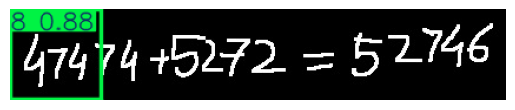

In [34]:
succes = 0

test_path = "/kaggle/input/hackathonnnnnn/WhatsApp Image 2025-03-22 at 17.09.48 (1).jpeg"
test_images = [test_path]
for img_name in test_images:
    image_path = os.path.join(test_path, img_name)
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_h, img_w = img.shape
    result = model.predict(source= image_path, conf=0.6, imgsz=[128,128*20])
    list_sorted_cls, sorted_cls   = model_imeage_cls_from_left_to_right(result)
    print(list_sorted_cls)
    succes += check_classifaction_success(img_name , result)

    img_with_boxes = result[0].plot()
    plt.imshow(cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off') 
    plt.show()